<a href="https://colab.research.google.com/github/yoe174/PCVK_27_3C/blob/main/KUIS_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [1]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## **Download Data-set dari Kaggle**

In [2]:
# Library tambahan untuk mengakses dataset dari Kaggle
from google.colab import files

# Unggah file kaggle.json dari komputer lokal
from google.colab import files
files.upload()

# Membuat direktori .kaggle dan memindahkan kaggle.json ke dalamnya
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset anjing dan kucing dari Kaggle (ganti dengan dataset yang sesuai)
!kaggle datasets download -d 'tongpython/cat-and-dog'

# Ekstrak dataset
!unzip cat-and-dog.zip -d ./dataset


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: ./dataset/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.371.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3715.jpg  
  inflating: ./dataset/training_set/training_

In [3]:
# Pengaturan direktori dataset
train_dir = './dataset/training_set/training_set'
test_dir = './dataset/test_set/test_set'

# Konfigurasi parameter
image_size = (224, 224)  # Ukuran input untuk MobileNetV2
batch_size = 32
learning_rate = 1e-4
epochs = 20

# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data generator untuk validasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load base model MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=image_size + (3,)
)

# Freeze base model layers
base_model.trainable = False

# Tambahkan layer klasifikasi custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step


## **Membuat Model**

In [4]:
# Buat model baru
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_checkpoint = ModelCheckpoint(
    'best_mobilenet_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## **Melakukan Training**

In [5]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9528
Epoch 1: val_accuracy improved from -inf to 0.98264, saving model to best_mobilenet_model.keras
250/250 [==============================] - 134s 524ms/step - loss: 0.1283 - accuracy: 0.9528 - val_loss: 0.0478 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9693
Epoch 2: val_accuracy improved from 0.98264 to 0.98413, saving model to best_mobilenet_model.keras
250/250 [==============================] - 130s 518ms/step - loss: 0.0755 - accuracy: 0.9693 - val_loss: 0.0434 - val_accuracy: 0.9841 - lr: 1.0000e-04
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9724
Epoch 3: val_accuracy did not improve from 0.98413
250/250 [==============================] - 128s 513ms/step - loss: 0.0700 - accuracy: 0.9724 - val_loss: 0.0499 - val_accuracy: 0.9812 - lr: 1.0000e-04
Epoch 4/20

## **Download Model**

In [6]:
# Setelah training
model.save('cat_dog_classifier_model.keras')

# Download model
from google.colab import files
files.download('cat_dog_classifier_model.keras')

# Buat ulang data generator untuk validasi (persis seperti saat training)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    test_dir,  # Pastikan variabel test_dir sudah didefinisikan sebelumnya
    target_size=(224, 224),  # Sesuaikan dengan ukuran input model
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 2023 images belonging to 2 classes.


NameError: name 'loaded_model' is not defined

In [12]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/cat_dog_classifier_model.keras')

# Evaluasi model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

64/64 [==============================] - 14s 200ms/step - loss: 0.0341 - accuracy: 0.9867
Test Loss: 0.03412480652332306
Test Accuracy: 0.9866535067558289


In [7]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

64/64 [==============================] - 13s 197ms/step - loss: 0.0341 - accuracy: 0.9867
Test Loss: 0.03412480652332306
Test Accuracy: 0.9866535067558289


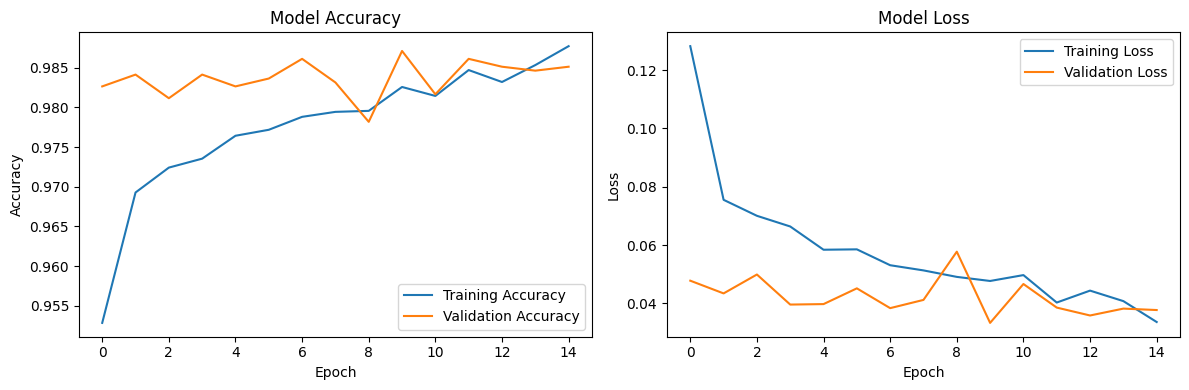

In [8]:
# Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Saving cat.png to cat.png


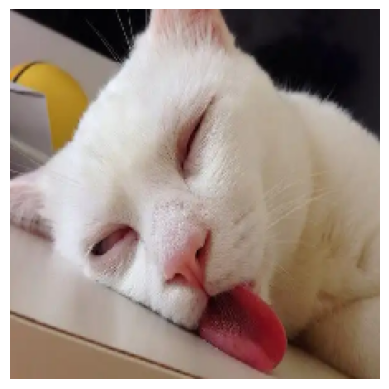

1/1 [==============================] - 0s 43ms/step
Probabilitas Anjing: 0.00018104983610101044
Probabilitas Kucing: 0.999818950163899
Hasil Prediksi: Kucing


In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

# Fungsi untuk memuat dan memprediksi gambar
def predict_image(img_path, model, threshold=0.6):
    # Memuat gambar dengan target_size yang sesuai dengan model (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))  # Ubah target_size menjadi (224, 224)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    plt.imshow(img)
    plt.axis('off')  # Menonaktifkan sumbu
    plt.show()

    # Prediksi
    prediction = model.predict(img_array)

    # Ambil probabilitas untuk kedua kelas
    prob_anjing = prediction[0][0]  # Probabilitas anjing
    prob_kucing = 1 - prob_anjing   # Probabilitas kucing (1 - prob_anjing)

    print(f"Probabilitas Anjing: {prob_anjing}")
    print(f"Probabilitas Kucing: {prob_kucing}")

    # Menentukan kategori berdasarkan ambang batas
    if prob_anjing > threshold:
        return "Anjing"
    elif prob_kucing > threshold:
        return "Kucing"
    else:
        return "Bukan Keduanya"

# Mengunggah gambar dan mengambil path
uploaded = files.upload()
# Get the first filename from the uploaded dictionary
for filename in uploaded.keys():
    img_path = filename
    break  # Stop after getting the first filename

# Contoh penggunaan
# img_path = 'path_to_your_image.jpg'  # Ganti dengan path gambar yang akan diuji
# img_path = files.upload()  # Ganti dengan path gambar yang akan diuji
result = predict_image(img_path, model)  # Pass the filename to predict_image
print(f"Hasil Prediksi: {result}")